In [ ]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def load_environment_data():
    """
    Loads fixed place cell, reward cell network data, environment data, and dynamically discovers scale files.

    Returns:
    - data (dict): A dictionary containing loaded network data, environment data, and layers for small/large fields.
    """
    data = {}

    # Load place cell and reward cell network data
    try:
        with open('pcn_small.pkl', 'rb') as f:
            data['small_pc_net'] = pickle.load(f)
        print("Loaded small PCN.")
    except FileNotFoundError as e:
        print(f"Error loading small PCN file: {e}")
        return None

    try:
        with open('pcn_large.pkl', 'rb') as f:
            data['large_pc_net'] = pickle.load(f)
        print("Loaded large PCN.")
        data['has_large_pcn'] = True  # Flag indicating large PCN exists
    except FileNotFoundError:
        print("Large PCN file not found. Assuming single-scale setup.")
        data['has_large_pcn'] = False

    try:
        with open('rcn.pkl', 'rb') as f:
            data['rc_net'] = pickle.load(f)
        print("Loaded reward cell network.")
    except FileNotFoundError as e:
        print(f"Error loading RCN file: {e}")
        return None

    # Load environment data (place cell and reward map coordinates)
    try:
        with open('hmap_x.pkl', 'rb') as f:
            data['hmap_x'] = pickle.load(f)
            print("Loaded hmap_x.")
        with open('hmap_y.pkl', 'rb') as f:
            data['hmap_y'] = pickle.load(f)
            print("Loaded hmap_y.")
        with open('hmap_g.pkl', 'rb') as f:
            data['hmap_g'] = np.asarray(pickle.load(f))
            print("Loaded hmap_g.")
        with open('hmap_vis_density.pkl', 'rb') as f:
            data['hmap_vis_density'] = np.asarray(pickle.load(f))
            print("Loaded hmap_vis_density.")
        with open('hmap_z_small.pkl', 'rb') as f:
            data['hmap_z_small'] = pickle.load(f)
            print("Loaded hmap_z_small.")
    except FileNotFoundError as e:
        print(f"Error loading environment data files: {e}")
        return None

    # Attempt to load large-scale place cell activations
    if data.get('has_large_pcn', False):
        try:
            with open('hmap_z_large.pkl', 'rb') as f:
                data['hmap_z_large'] = pickle.load(f)
                print("Loaded hmap_z_large.")
        except FileNotFoundError:
            print("hmap_z_large file not found. Assuming single-scale setup.")
            data['hmap_z_large'] = None

    # Set goal properties
    data['goal_r'] = 0.05  # Goal radius
    data['goal_location'] = [-1, 1]  # Goal location

    return data

data = load_environment_data()

Loaded small PCN.
Large PCN file not found. Assuming single-scale setup.
Loaded reward cell network.
Loaded hmap_x.
Loaded hmap_y.
Loaded hmap_g.
Loaded hmap_vis_density.
Loaded hmap_z_small.


C:\Users\bduke\AppData\Local\Temp\ipykernel_22328\3786144767.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("plasma")


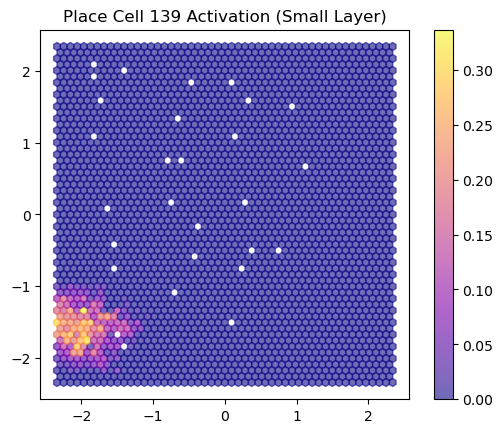

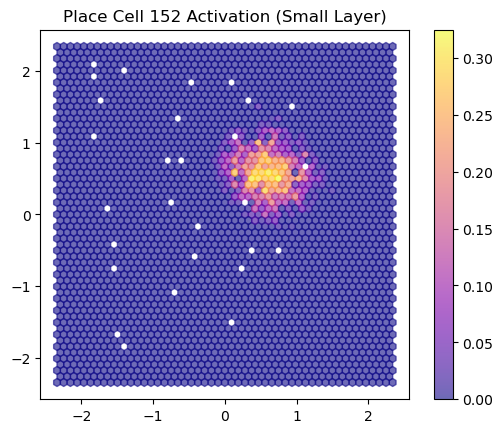

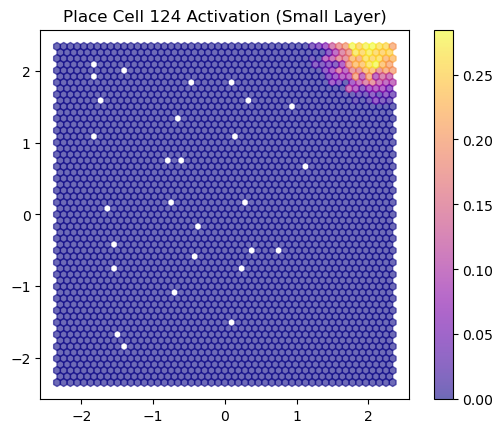

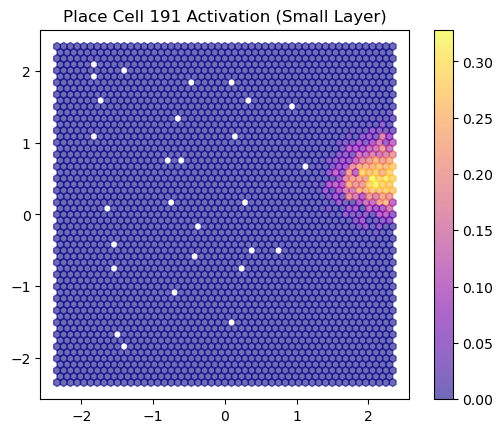

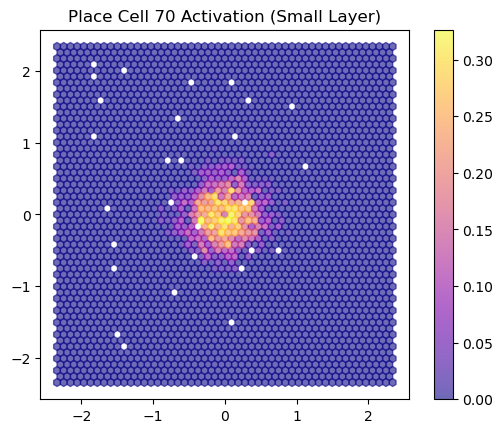

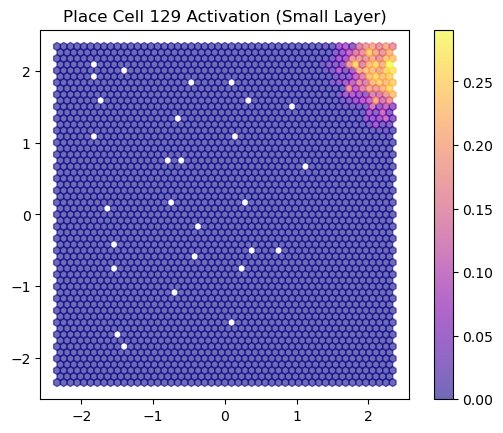

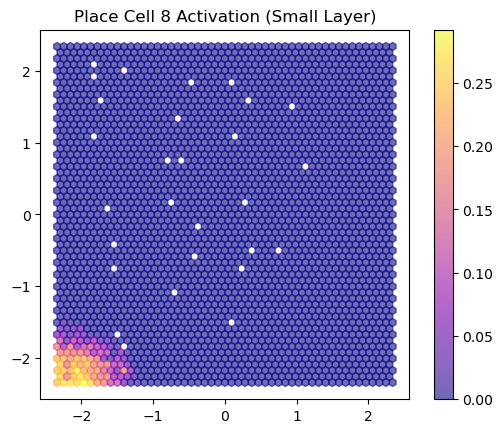

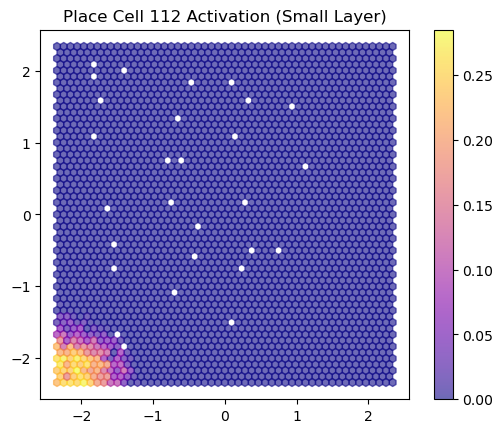

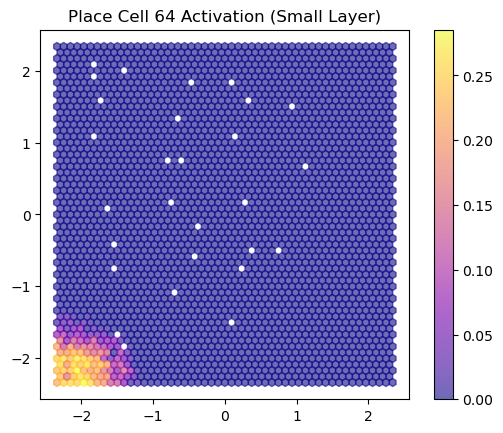

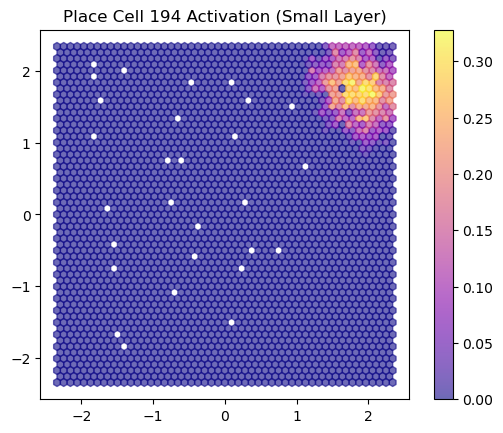

Large layer not available. Skipping large-scale visualizations.


In [26]:
def probeOne(probed, layer, data):
    """
    Visualizes the activation of a specific place cell (probed) over the environment map.

    Parameters:
    - probed (int): The index of the place cell to visualize.
    - layer (str): Either 'small' or 'large', indicating the layer to plot.
    - data (dict): The loaded environment data, including hmap_x, hmap_y, and activations for small/large layers.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = get_cmap("plasma")

    if layer == "small":
        activations = data['hmap_z_small'][:, probed]
        title = f"Place Cell {probed} Activation (Small Layer)"
    elif layer == "large":
        if not data.get('has_large_pcn', False):
            print("Large layer not available. Skipping visualization.")
            return
        activations = data['hmap_z_large'][:, probed]
        title = f"Place Cell {probed} Activation (Large Layer)"
    else:
        raise ValueError("Layer must be either 'small' or 'large'.")

    # Plot the activations
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")

    # Create a hexbin plot for place cell activations
    cntr = ax.hexbin(hmap_x, hmap_y, activations, gridsize=50, cmap=cmap, alpha=0.6)

    # Add colorbar and title
    plt.colorbar(cntr)
    plt.title(title)
    plt.show()

# Calculate the total activation for the small layer
total_activations_small = np.sum(data['hmap_z_small'], axis=0)
top_cells_small = np.argsort(total_activations_small)[-10:]

# Visualize the top 10 cells in the small layer
for cell in top_cells_small:
    probeOne(cell, "small", data)

# Calculate and visualize the large layer only if it exists
if data.get('has_large_pcn', False) and data.get('hmap_z_large') is not None:
    total_activations_large = np.sum(data['hmap_z_large'], axis=0)
    top_cells_large = np.argsort(total_activations_large)[-10:]
    for cell in top_cells_large:
        probeOne(cell, "large", data)
else:
    print("Large layer not available. Skipping large-scale visualizations.")


In [27]:
def plot_overlaid_pcn_activations(data):
    """
    Plots the place cell activations for all scales in the provided data.

    Parameters:
    - data (dict): A dictionary containing hmap_x, hmap_y, and a list of hmap_z_scales.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    hmap_z_scales = data['hmap_z_scales']

    cmap = get_cmap("plasma")  # Use the plasma colormap

    for i, hmap_z in enumerate(hmap_z_scales):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_aspect("equal")
        ax.set_title(f"Aggregate Place Cell Activations (Scale {i})")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        # Compute and plot activations for the current scale
        total_activation = np.sum(hmap_z, axis=1)
        hb = ax.hexbin(
            hmap_x,
            hmap_y,
            total_activation,
            gridsize=50,
            cmap=cmap,
            reduce_C_function=np.mean,
            alpha=0.8,
        )

        # Add colorbar and labels
        cb = plt.colorbar(hb, ax=ax)
        cb.set_label(f"Total Activation")

        plt.show()

plot_overlaid_pcn_activations(data)

KeyError: 'hmap_z_scales'

Loaded small PCN.
Large PCN file not found. Assuming single-scale setup.
Loaded reward cell network.
Loaded hmap_x.
Loaded hmap_y.
Loaded hmap_g.
Loaded hmap_vis_density.
Loaded hmap_z_small.


C:\Users\bduke\AppData\Local\Temp\ipykernel_22328\619401184.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("plasma")


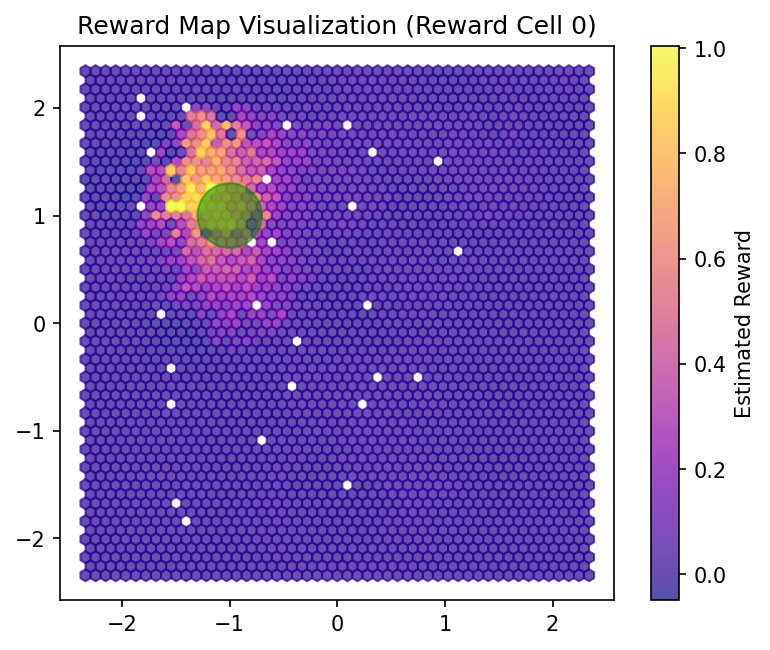

In [36]:
import tensorflow as tf

def plot_rcn_activation():
    """
    Visualizes the reward cell activations across the environment using 
    the RCN's effective weights (w_in_effective).
    
    Hardcoded for reward cell index 0 and a grid size of 50.
    """
    # 1) Load environment data
    data = load_environment_data()
    if data is None:
        print("No environment data found. Check your file paths or saving logic.")
        return
    
    if 'rc_net' not in data:
        print("Could not find RCN data (rc_net) in the loaded dictionary.")
        return

    rc_net = data['rc_net']              # The RewardCellLayer object
    hmap_x = data['hmap_x']             # Shape: (num_steps,)
    hmap_y = data['hmap_y']             # Shape: (num_steps,)
    hmap_z_small = data['hmap_z_small'] # Shape: (num_steps, num_place_cells)
    goal_location = data['goal_location']
    goal_r = data['goal_r']

    # Hardcoded settings
    reward_cell_index = 0  # Index of the reward cell to visualize
    gridsize = 50          # Grid size for the hexbin plot

    # Optional color map
    cmap = get_cmap("plasma")
    
    # 2) Convert needed arrays to tf.float32
    hmap_z_small_tf = tf.cast(hmap_z_small, tf.float32)

    # We pick one row for the chosen reward_cell_index
    w_in_effective = rc_net.w_in_effective[reward_cell_index]  # shape: (input_dim,)

    # 3) Compute total place cell activation per step to avoid divide-by-zero
    sum_activations = tf.reduce_sum(hmap_z_small_tf, axis=1)  # shape: (num_steps,)
    safe_denominator = tf.where(sum_activations > 0, sum_activations, 1.0)
    safe_denominator = tf.cast(safe_denominator, tf.float32)

    # 4) Tensordot: reward_function = (w_in_effective . hmap_z_small) / sum_activations
    hmap_z_small_t = tf.transpose(hmap_z_small_tf)  # shape: (input_dim, num_steps)
    reward_function = tf.tensordot(w_in_effective, hmap_z_small_t, axes=1)
    reward_function /= safe_denominator  # element-wise division

    # Squeeze to ensure 1D
    reward_function = tf.squeeze(reward_function)

    # 5) Check shape compatibility 
    if reward_function.shape[0] != hmap_x.shape[0]:
        raise ValueError(f"Shape mismatch: reward_function has shape {reward_function.shape}, "
                         f"but expected {hmap_x.shape} based on hmap_x.")

    # 6) Plot via hexbin
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect('equal')

    # Make a hexbin plot
    cntr = ax.hexbin(hmap_x, hmap_y, reward_function.numpy(), gridsize=gridsize, cmap=cmap, alpha=0.7)
    
    # Goal circle
    goal_circle = plt.Circle(goal_location, goal_r, color='green', alpha=0.5, fill=True)
    ax.add_patch(goal_circle)

    # Add colorbar
    cbar = fig.colorbar(cntr, ax=ax)
    cbar.set_label("Estimated Reward")

    plt.title(f"Reward Map Visualization (Reward Cell {reward_cell_index})")
    plt.show()

# Hardcoded function call
plot_rcn_activation()


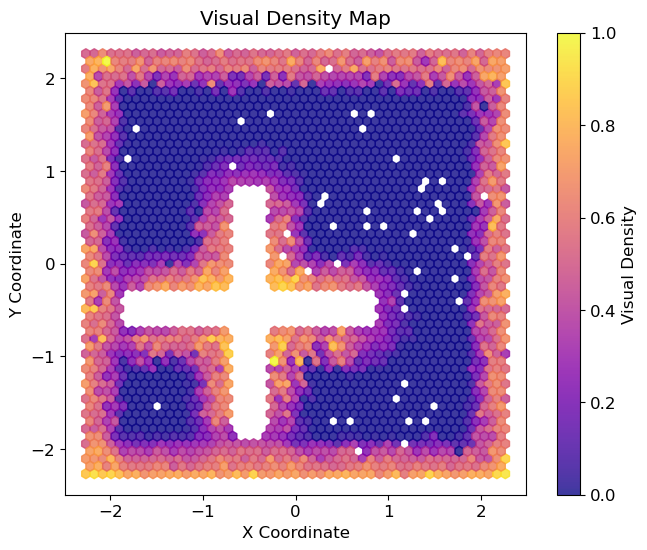

In [ ]:
def plot_vis_density(data):
    """
    Visualizes the visual density over the environment map using hexbin plotting.

    Parameters:
    - data (dict): A dictionary containing hmap_x, hmap_y, and hmap_vis_density.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    hmap_vis_density = data['hmap_vis_density']

    # Set up the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_title("Visual Density Map")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

    # Create a hexbin plot for visual density
    hb = ax.hexbin(
        hmap_x, hmap_y, hmap_vis_density, gridsize=50, cmap=cmap, reduce_C_function=np.mean, alpha=0.8
    )

    # Add colorbar and labels
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label("Visual Density")

    # Show the plot
    plt.show()

plot_vis_density(data)